In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# Intel Stock Price Prediction

## Time Series Analysis

* EDA
* Linear Regression 
* LSTM

### EDA

Our initial dataset consisted of the 30 Dow Jones Industrial Average stocks. We decided to choose only one stock, INTC, in order to produce a working model within the time allotted.

* Train window : 90 days 
* Prediction window : 10 days

In [4]:
df = pd.read_csv('data/INTC.csv')

In [5]:
df.head()


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,25.19,25.64,24.90,25.57,56409085,INTC
1,2006-01-04,25.60,25.94,25.59,25.91,46189650,INTC
2,2006-01-05,25.93,26.47,25.91,26.27,54893195,INTC
3,2006-01-06,26.48,26.63,26.21,26.31,45703307,INTC
4,2006-01-09,26.39,26.51,26.09,26.47,39461729,INTC


In [6]:
# convert df['Date'] columns to date type select dates 
def date_filter(df, start_date):
    df.reset_index(level=0, inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'] >= start_date][['Date', 'Adj. Close']]  
    return df 

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

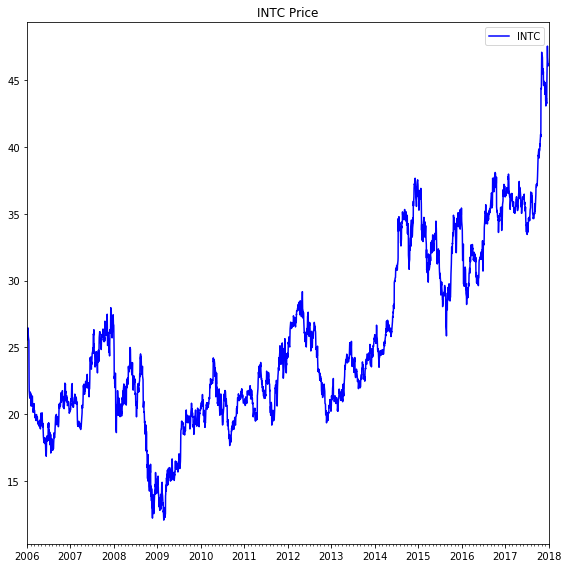

In [17]:
### Plot Price Action of INTC
# Setup date locator items for plotting/ x-axis
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(1, 1, figsize=(8,8))
    
symbol = 'INTC'
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
datemin = datetime.date(df.Date.min().year, 1, 1)
datemax = datetime.date(df.Date.max().year + 1, 1, 1)
ax.set_xlim(datemin, datemax)
ax.plot(df.Date, df['Close'], label=f'{symbol}', color='b')
ax.set_title(f'{symbol} Price')
plt.legend()
plt.tight_layout()

In [30]:
df.tail()

,Date,Open,High,Low,Close,Volume,Name,Growth
3014,2017-12-22,46.33,47.02,46.02,46.70,33913537,INTC,-0.001283
3015,2017-12-26,46.28,46.47,45.95,46.08,15533328,INTC,-0.013276
3016,2017-12-27,46.11,46.36,46.00,46.11,13359671,INTC,0.000651
3017,2017-12-28,46.36,46.36,45.95,46.22,9504372,INTC,0.002386
3018,2017-12-29,46.21,46.49,46.09,46.16,17394491,INTC,-0.001298


In [22]:
close_values = df['Close'].values
INTC_var = np.var(close_values)
INTC_sig = np.sqrt(INTC_var)

In [23]:
INTC_sig

6.727585375767282

In [25]:
df.describe()


,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.00000,3.019000e+03
mean,25.396744,25.659096,25.142136,25.40789,4.919834e+07
std,6.715544,6.728572,6.700110,6.72870,2.817910e+07
min,12.170000,12.630000,12.050000,12.08000,5.893789e+06
25%,20.645000,20.880000,20.415000,20.66000,2.736445e+07
50%,23.600000,23.860000,23.320000,23.58000,4.519099e+07
75%,30.810000,31.105000,30.500000,30.85500,6.363350e+07
max,47.540000,47.640000,46.660000,47.56000,3.100734e+08


In [26]:
df['Growth'] = (df['Close']/df['Close'].shift(1)) - 1

In [41]:
df.describe()
df.head()

,Date,Open,High,Low,Close,Volume,Name,Growth
0,2006-01-03,25.19,25.64,24.90,25.57,56409085,INTC,NaN
1,2006-01-04,25.60,25.94,25.59,25.91,46189650,INTC,0.013297
2,2006-01-05,25.93,26.47,25.91,26.27,54893195,INTC,0.013894
3,2006-01-06,26.48,26.63,26.21,26.31,45703307,INTC,0.001523
4,2006-01-09,26.39,26.51,26.09,26.47,39461729,INTC,0.006081


In [ ]:
df_close = df[['Date','Close']]
df_close.head()
train_set = df_close[df_close.Date.dt.year != 2017].Close.values 
test_set =  df_close[df_close.Date.dt.year == 2017].Close.values

In [ ]:
scaler = MinMaxScaler()
training_set_scaled = scaler.fit_transform(train_set.reshape(-1, 1))

In [ ]:
def create_train_data(training_set_scaled):
    X_train, y_train = [], []
    for i in range(30, training_set_scaled.size):
        X_train.append(training_set_scaled[i-30: i])
        y_train.append(training_set_scaled[i])
    # Converting list to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    return X_train, y_train

In [67]:
def create_test_data():
    X_test = []
    inputs = df_close[len(df_close) - len(test_set) - 30:].Close.values
    inputs = scaler.transform(inputs.reshape(-1, 1))
    for i in range(30, test_set.size+30): # Range of the number of values in the training dataset
        X_test.append(inputs[i - 30: i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

In [53]:
def create_simple_model():
    model = Sequential()
    model.add(LSTM(units = 10, return_sequences = False, input_shape = (X_train.shape[1], 1)))
    model.add(Dense(units = 1))
    return model

In [54]:
def compile_and_run(model, epochs=50, batch_size=64):
    model.compile(metrics=['accuracy'], optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=3)
    return history

In [ ]:
def plot_metrics(history):
    metrics_df = pd.DataFrame(data={"loss": history.history['loss']})
    metrics_df.plot()

In [65]:
def make_predictions(X_test, model):
    y_pred = model.predict(X_test)
    final_predictions = scaler.inverse_transform(y_pred)
    fp = np.ndarray.flatten(final_predictions)
    ap = np.ndarray.flatten(test_set)
    pdf = pd.DataFrame(data={'Actual': ap, 'Predicted': fp})
    ax = pdf.plot()

In [62]:
X_train, y_train = create_train_data(training_set_scaled)
X_test = create_test_data()

In [63]:
simple_model = create_simple_model()
history = compile_and_run(simple_model, epochs=20)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


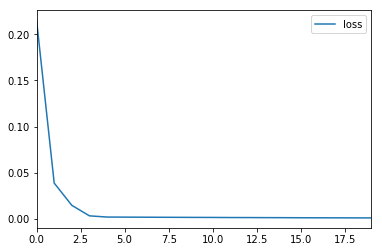

In [64]:
plot_metrics(history)

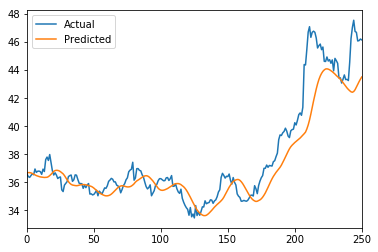

In [66]:
make_predictions(X_test, simple_model)

In [69]:
df_2017 = df_close[df_close.Date.dt.year == 2017].Close.values

In [73]:
return_2017 = (df_2017[-1]/df_2017[0]) - 1 

In [74]:
return_2017

0.26120218579234966